<a href="https://colab.research.google.com/github/TheeraphatKhiangphukhiao/artificial-intelligence/blob/main/LAB_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ทำการ import library ที่จำเป็น**

In [ ]:
import nltk
from nltk.corpus import stopwords
import re
import joblib
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**ทำการอ่าน data**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI Deep Learning/Dataset/Message Dataset/training-twitter.csv',encoding='latin-1',header=None)

**แสดงตัวอย่างของ data**

In [ ]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**ทำการ Random สลับตำเเหน่งของ row เพื่อให้ได้ข้อมูลที่มีประสิทธิภาพ เเละ เคลียร์ข้อมูลของ DataFrame ออกไป**

In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.head(100000)
df.head()

,0,1,2,3,4,5
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


**ทำการกำหนดชื่อ column และแทนชื่อ column ลงใน data**

In [ ]:
columns=['target', 'ids', 'date', 'flag', 'user', 'text']
df.columns = columns

**แสดงตัวอย่างข้อมูลอีกครั้ง และตรวจสอบว่ามีชื่อ column ถูกต้องหรือไม่**

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


**ทำการเปลี่ยน column target จากตัวเลข (0, 1, 2) ที่เป็นคลาสของข้อความ ให้เป็นคำ**

In [ ]:
df.target.replace({0:'Negative', 2:'Neutral', 4:'Positive'}, inplace=True)

**เเสดงตัวอย่างข้อมูลอีกครั้ง เพื่อตรวจสอบผลลัพธ์ใน column target**

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,Negative,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,Negative,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,Negative,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,Negative,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,Negative,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


**Data Pre-Processing**
     ใน twitter จะมี emoticon สัญลักษณ์พิเศษ เช่น @ หรือ # นอกจากนั้นจะมีคำที่มีอักษรที่ซํ้ากัน เช่น
hapyyyyy ในขั้นตอนนี้ทำการทำให้ข้อความเป็นตัวพิมพ์เล็กและ ทำการเอา @ # และ emoticon ออก ทำการลบคำที่ไม่มีผลต่อการประมวลผลออก เช่น the a an ซึ่งเรียกว่า stop-word ทำการทำ stemming word หรือ จัดการรากศัพท์ของคำ เช่น คน กับ มนุษย์ จะถือว่าเป็นคำเดียวกัน

**ทำการดึง stop-word ซึ่งมีการเก็บรวบรวมไว้แล้วว่ามีคำใดบ้างมาแล้วลบออกจากข้อความทั้งหมด**

In [ ]:
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
stop_words.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
corpus=[]
for i in range(0,len(df)):
  review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+',' ', df['text'][i])
  review=review.lower()
  review=review.split()
  review=[word for word in review if not word in stop_words]
  review=' '.join(review)
  corpus.append(review)

**จากนั้นนำผลลัพธ์กลับไปแทนค่าใน column text**

In [ ]:
df.text=corpus

**ทำการแสดงข้อมูลอีกครั้งจะต้องได้ผลดังนี้**

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,Negative,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,ahhh hope ok
1,Negative,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,cool tweet apps razr 2
2,Negative,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,know family drama lame hey next time u hang ki...
3,Negative,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,school email open geography stuff revise stupi...
4,Negative,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


**ทำการแบ่งข้อมูลสำหรับ train และ test**

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df=train_test_split(df, test_size=0.20, random_state=123)

**ทำการแสดงข้อมูลทั้ง test และ train ด้วย .head()**

In [ ]:
# train_df.head()
test_df.head()

,target,ids,date,flag,user,text
42083,Negative,2296582663,Tue Jun 23 09:21:44 PDT 2009,NO_QUERY,roxfox01,hey jen sadly guessing awsomeness hear click c...
71825,Positive,1974853506,Sat May 30 13:57:26 PDT 2009,NO_QUERY,themement,fam like dress
99535,Negative,1978859250,Sun May 31 00:43:06 PDT 2009,NO_QUERY,MeccaStarr,uggggh one doritos fell cup juice
47879,Positive,2055025041,Sat Jun 06 08:33:14 PDT 2009,NO_QUERY,sid88,tweeting phone bro
36734,Positive,2016498266,Wed Jun 03 06:52:57 PDT 2009,NO_QUERY,NKOTBnurse,aww poor thing wrong need nurse


ทำการสร้าง vector ในการแสดงตัวแทนของคำ โดยแทนที่เราจะแสดงข้อมูลเป็นคำ เราจะทำการสร้างชุดตัวเลข
ขึ้นมาเพื่อแทนคำ โดยคำที่มีความหมายใกล้เคียงกัน ชุดตัวเลขนั้นจะต้องมีค่าใกล้เคียงกันด้วย เทคนิคที่จะใช้ทำ
เรียกว่า word2vec (word to vector นั้นเอง) โดยเราจะสร้างจากข้อมูลชุด train ดังนี้ สร้าง document จากข้อมูลทั้งหมด โดย document คือ เอกสารที่ประกอบไปด้วยประโยดต่างๆ ข้อมูลเดิมเป็น data frame เราจะทำการสร้าง document ที่เป็น list ขึ้นมา

In [ ]:
documents = [text.split() for text in train_df.text]

In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=300, window=7, min_count=10, workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 5509


In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(13742090, 17515050)

**ทำการตรวจสอบว่า w2v_model ที่เราสร้างขึ้นมาสามารถ สร้าง vector ที่มีความหมายได้**

**ทดสอบคำที่มีความหมายใกล้เคียงกับคำว่า “good”**

In [ ]:
w2v_model.wv.most_similar("good")

[('great', 0.4321794807910919),
 ('goood', 0.41485241055488586),
 ('gud', 0.3848884403705597),
 ('bad', 0.38299378752708435),
 ('rough', 0.3475138545036316),
 ('tough', 0.3450535833835602),
 ('fine', 0.3337807059288025),
 ('excellent', 0.331525057554245),
 ('best', 0.3294385075569153),
 ('productive', 0.32820287346839905)]

**ทดสอบกับคำว่า “hate” “love” “great”**

In [ ]:
w2v_model.wv.most_similar("hate")

[('various', 0.38589516282081604),
 ('ugh', 0.38443970680236816),
 ('suck', 0.37735599279403687),
 ('ughh', 0.372416228055954),
 ('stupid', 0.35546445846557617),
 ('mondays', 0.33870723843574524),
 ('scare', 0.3327963352203369),
 ('hates', 0.32184913754463196),
 ('eww', 0.3201935291290283),
 ('kills', 0.3078608214855194)]

**ทำการนำคำทั้งหมดในชุด train มาสร้าง index หรือ หมายเลขกำกับ**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df.text)

In [ ]:
tokenizer.word_index

{'not': 1,
 'good': 2,
 'day': 3,
 'get': 4,
 'like': 5,
 'quot': 6,
 'go': 7,
 'today': 8,
 'work': 9,
 'love': 10,
 'going': 11,
 'got': 12,
 'lol': 13,
 'time': 14,
 'back': 15,
 'one': 16,
 'u': 17,
 'know': 18,
 'really': 19,
 'im': 20,
 'amp': 21,
 'see': 22,
 'well': 23,
 'night': 24,
 '2': 25,
 'still': 26,
 'want': 27,
 'think': 28,
 'new': 29,
 'oh': 30,
 'thanks': 31,
 'home': 32,
 'much': 33,
 'need': 34,
 'miss': 35,
 'last': 36,
 'hope': 37,
 '3': 38,
 'morning': 39,
 'great': 40,
 'twitter': 41,
 'tomorrow': 42,
 'haha': 43,
 'feel': 44,
 'sad': 45,
 'would': 46,
 'wish': 47,
 'right': 48,
 'fun': 49,
 'bad': 50,
 'sorry': 51,
 'sleep': 52,
 'make': 53,
 'happy': 54,
 'tonight': 55,
 'nice': 56,
 'come': 57,
 'way': 58,
 'though': 59,
 'watching': 60,
 'getting': 61,
 'better': 62,
 'wait': 63,
 'gonna': 64,
 'could': 65,
 'week': 66,
 'bed': 67,
 'yeah': 68,
 'people': 69,
 'lt': 70,
 'even': 71,
 'hate': 72,
 'school': 73,
 'days': 74,
 'next': 75,
 'yes': 76,
 '4': 77

**ตรวจสอบความยาวของคำในชุดข้อมูล หรือ จะเรียกว่า dictionary**

In [ ]:
vocab_size=len(tokenizer.word_index)+1
vocab_size

50679

**ทำการ pad sequence ของ input train และ test**

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_df.text), maxlen=300)
X_train

array([[    0,     0,     0, ...,   605,    32,    95],
       [    0,     0,     0, ...,   446,  4753,   114],
       [    0,     0,     0, ...,     0,    31,  1244],
       ...,
       [    0,     0,     0, ...,   668,  1727,     7],
       [    0,     0,     0, ...,   326,   106,   444],
       [    0,     0,     0, ...,     7,    73, 50678]], dtype=int32)

In [ ]:
X_test = pad_sequences(tokenizer.texts_to_sequences(test_df.text), maxlen=300)
X_test

array([[   0,    0,    0, ...,  806,   11,    9],
       [   0,    0,    0, ...,  936,    5,  828],
       [   0,    0,    0, ...,  715,  891, 1623],
       ...,
       [   0,    0,    0, ...,    5,  417, 4617],
       [   0,    0,    0, ..., 1469,   96,  219],
       [   0,    0,    0, ..., 2476,  954, 1160]], dtype=int32)

**ทำการดีงข้อมูล target หรือ y ออกมาจาก data frame ทั้ง train และ test**

In [ ]:
y_train=train_df.target
y_train.head()

22302    Positive
49609    Positive
89251    Positive
96385    Positive
17569    Positive
Name: target, dtype: object

In [ ]:
y_test=test_df.target
y_test.head()

42083    Negative
71825    Positive
99535    Negative
47879    Positive
36734    Positive
Name: target, dtype: object

**ทำการสร้าง one hot vector สำหรับ target หรือ y**

In [ ]:
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test=labelencoder.fit_transform(y_test)

**ทำการจัดข้อมูล input เพื่อที่จะนำเข้าสู่ LSTM**

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(50679, 300)


**ทำการสร้าง input later หรือเราจะเรียกว่า embedding layer**

In [ ]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

**ทำการสร้าง LSTM**

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          15203700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 15364201 (58.61 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 15203700 (58.00 MB)
_________________________________________________________________


**ทำการ train model**

In [ ]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [ ]:
model_history=model.fit(X_train, y_train, batch_size=1024, epochs=15, validation_split=0.1, verbose=1)

Epoch 1/15
71/71 [==============================] - 96s 1s/step - loss: 0.5791 - accuracy: 0.6916 - val_loss: 0.5204 - val_accuracy: 0.7410
Epoch 2/15
71/71 [==============================] - 106s 2s/step - loss: 0.5407 - accuracy: 0.7249 - val_loss: 0.5072 - val_accuracy: 0.7498
Epoch 3/15
71/71 [==============================] - 113s 2s/step - loss: 0.5281 - accuracy: 0.7352 - val_loss: 0.5020 - val_accuracy: 0.7491
Epoch 4/15
71/71 [==============================] - 108s 2s/step - loss: 0.5176 - accuracy: 0.7396 - val_loss: 0.4990 - val_accuracy: 0.7534
Epoch 5/15
71/71 [==============================] - 102s 1s/step - loss: 0.5114 - accuracy: 0.7456 - val_loss: 0.4947 - val_accuracy: 0.7552
Epoch 6/15
71/71 [==============================] - 116s 2s/step - loss: 0.5067 - accuracy: 0.7477 - val_loss: 0.4934 - val_accuracy: 0.7586
Epoch 7/15
71/71 [==============================] - 92s 1s/step - loss: 0.5022 - accuracy: 0.7498 - val_loss: 0.4930 - val_accuracy: 0.7560
Epoch 8/15
71/7

**ทำการ plot graph**

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))

Text(0.5, 1.0, 'Training and Validation Accuracy')

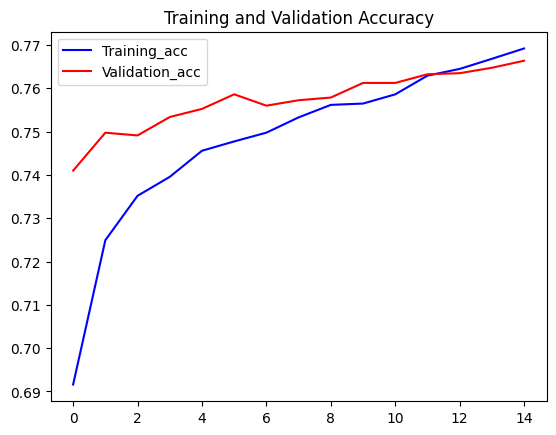

In [ ]:
plt.plot(epochs, acc, label='Training_acc', color='blue')
plt.plot(epochs, val_acc, label='Validation_acc', color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

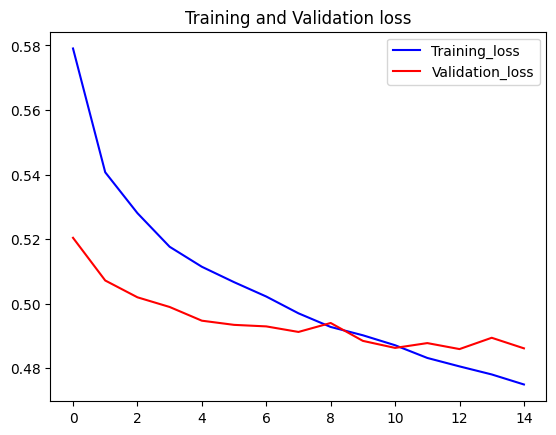

In [ ]:
plt.plot(epochs, loss, label='Training_loss', color='blue')
plt.plot(epochs, val_loss, label='Validation_loss', color='red')
plt.legend()
plt.title("Training and Validation loss")

**ลองสร้างตัว test เพื่อทดสอบ**

**สร้าง function process สำหรับ processing ข้อมูล text**

In [ ]:
def preprocess(text):
  review=re.sub('@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+', ' ', text)
  review=review.lower()
  review=review.split()
  review=[word for word in review if not word in stop_words]
  print(review)
  review=pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=300)
  return review

**สร้าง function predict สำหรับจำแนกประโยค**

In [ ]:
def prediction(review):
  review=preprocess(review)
  score=model.predict(review)
  score=score[0]
  if score<0.4:
    print('Negative')
  elif score>0.4 and score<0.6:
    print('Neutral')
  else:
    print('Positive')
  print(score)

**ทดสอบ**

In [ ]:
prediction("the food is not bad")

['food', 'not', 'bad']
1/1 [==============================] - 0s 299ms/step
Negative
[0.3367486]


In [ ]:
prediction("the film was horrible")

['film', 'horrible']
1/1 [==============================] - 0s 86ms/step
Negative
[0.06908993]


In [ ]:
prediction("You are very cute.")

['cute']
1/1 [==============================] - 0s 132ms/step
Positive
[0.9835789]


**วัดประสิทธิภาพ**

**นำชุด test มาทดสอบ**

In [ ]:
scores = model.predict(X_test, verbose=1, batch_size=1024)

**ทำการ threshold ผลลัพธ์ ถ้ามีค่า score มากกว่า 0.5 จะมีค่าเป็น 1**

In [ ]:
y_pred=np.where(scores>0.5, 1, 0)

**สร้าง confusion matrix**

In [ ]:
cm=confusion_matrix(y_pred, y_test)
print(cm)

**แสดงผล**

In [ ]:
print(accuracy_score(y_pred, y_test))

**รายงานสรุปผล**

In [ ]:
print(classification_report(y_test, y_pred))

**Save model ด้วย pickle**

In [ ]:
joblib.dump(w2v_model, 'word2vec.pkl')
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(model, 'final_model.pkl')